In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
# Catboost worked best so far - Score 0.887 (1.00 max, 0.00 min) - Ran out of time for more testing
from catboost import CatBoostClassifier, Pool
import warnings
warnings.filterwarnings("ignore")
## DT 2nd best so far - 0.76 score with real data
# from sklearn.tree import DecisionTreeClassifier
# Rest was removed

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# /kaggle/input/ - read only 
# /kaggle/working/ - read/write - apperently not since this didnt save my prev data
# /kaggle/temp/ - temp for this session

In [3]:
# Define paths
train_path = "/kaggle/input/playground-series-s4e1/train.csv"
test_path = "/kaggle/input/playground-series-s4e1/test.csv"
working_dir = "/kaggle/working/"

In [4]:
train_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)

In [5]:
print(train_raw.columns,train_raw.shape)
train_raw.head()

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object') (165034, 14)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
train_raw.dtypes

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [7]:
# Shape is 165034, 14
train_raw.nunique(0)

id                 165034
CustomerId          23221
Surname              2797
CreditScore           457
Geography               3
Gender                  2
Age                    71
Tenure                 11
Balance             30075
NumOfProducts           4
HasCrCard               2
IsActiveMember          2
EstimatedSalary     55298
Exited                  2
dtype: int64

In [8]:
train_raw.describe()
# Balance, EstimatedSalary are of interest due to their std/min/max

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [9]:
train_encoded = pd.get_dummies(train_raw, columns=["Geography","Gender"])
test_encoded = pd.get_dummies(test_raw, columns=["Geography","Gender"])

In [10]:
print(train_encoded.shape)
train_encoded.dtypes

(165034, 17)


id                     int64
CustomerId             int64
Surname               object
CreditScore            int64
Age                  float64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard            float64
IsActiveMember       float64
EstimatedSalary      float64
Exited                 int64
Geography_France        bool
Geography_Germany       bool
Geography_Spain         bool
Gender_Female           bool
Gender_Male             bool
dtype: object

In [11]:
train_encoded.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,True,False,False,False,True
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,True,False,False,False,True
2,2,15694510,Hsueh,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,True,False,False,False,True
3,3,15741417,Kao,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,True,False,False,False,True
4,4,15766172,Chiemenam,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,False,False,True,False,True


In [ ]:
train_encoded = train_encoded.drop(columns=["Surname"])
test_encoded = test_encoded.drop(columns=["Surname"])

In [14]:
train_encoded.head()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0,15674932,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,True,False,False,False,True
1,1,15749177,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,True,False,False,False,True
2,2,15694510,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,True,False,False,False,True
3,3,15741417,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,True,False,False,False,True
4,4,15766172,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,False,False,True,False,True


In [15]:
# Save new dataframe
train_encoded.to_csv(working_dir + "train_encoded.csv")
test_encoded.to_csv(working_dir + "test_encoded.csv")

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

<Axes: >

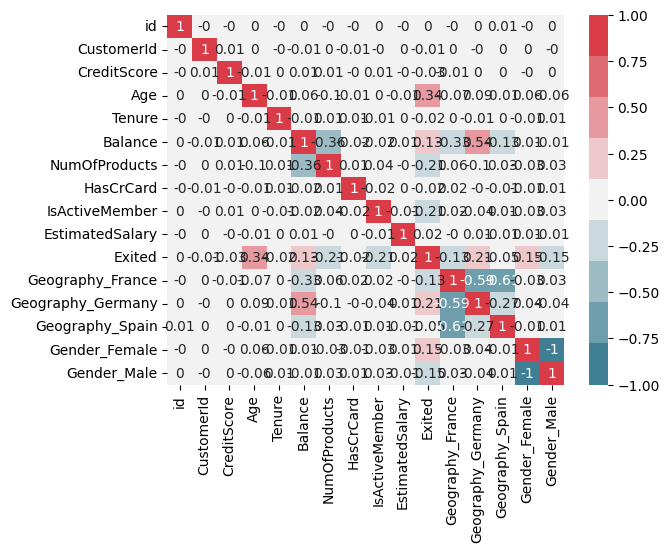

In [16]:
corr = train_encoded.corr().round(2)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True,
           cmap=sns.choose_diverging_palette())

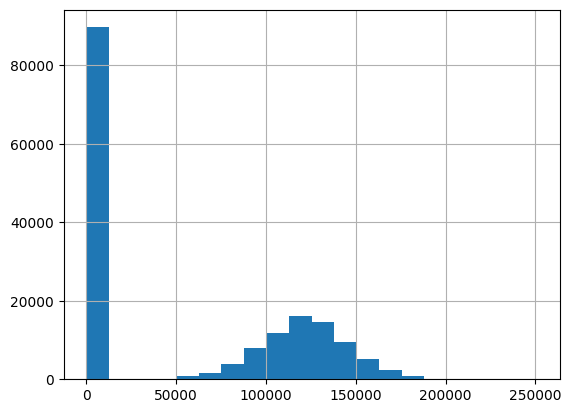

In [17]:
histBalance = train_encoded.Balance.hist(bins=20) # Zero inflated

In [18]:
# This one works as good as the one below, but training time is negatively impacted
#independentVars = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Female", "Gender_Male"]
# Works best so far
independentVars = ["Age", "Balance", "NumOfProducts", "IsActiveMember", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Female", "Gender_Male"]
dependentVars = ["Exited"]
train_encoded.dtypes

id                     int64
CustomerId             int64
CreditScore            int64
Age                  float64
Tenure                 int64
Balance              float64
NumOfProducts          int64
HasCrCard            float64
IsActiveMember       float64
EstimatedSalary      float64
Exited                 int64
Geography_France        bool
Geography_Germany       bool
Geography_Spain         bool
Gender_Female           bool
Gender_Male             bool
dtype: object

In [19]:
##### used with gridsearchCV - No longer used (as well as the training below
# param_grid = {
#     "solver":["adam"],
#     "hidden_layer_sizes":[(50, 4)],
#     "activation":["tanh"],
#     "alpha":[0.001, 0.0001],
#     "learning_rate_init":[0.001, 0.0001],
#     "max_iter":[100, 200, 500]
# #     "verbose":[True]
# # The best parameters across ALL searched params:
# #  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 4), 'learning_rate_init': 0.0001, 'max_iter': 500, 'solver': 'adam'}
# # Starting fold 2
# }

In [20]:
# kf = KFold(n_splits=2, random_state=None, shuffle=False)
# kf.get_n_splits(train_encoded)
# # KFold(n_splits=5, random_state=None, shuffle=False,)
# for i, (train_index, test_index) in enumerate(kf.split(train_encoded)):
#     print(f"Starting fold {i + 1}")
#     X = train_encoded.iloc[list(train_index)]
#     Y = train_encoded.iloc[list(test_index)]
#     train_X = X.loc[:,independentVars]
#     train_Y = X.loc[:,dependentVars]
#     test_X = Y.loc[:,independentVars]
#     test_Y = Y.loc[:,dependentVars]
#     criterion = "log_loss"
#     max_depth = [1,2,4,8,16,32]
#     min_samples_split = [2,4,8,16,32,64]
#     min_samples_leaf = [1,2,4,8,16,32]
#     minLoss = [0, 0, 0, 10000]
# #     for j in range(len(max_depth)):
# #         for k in range(len(max_depth)):
# #             for l in range(len(max_depth)):
# #     decisionTree = DecisionTreeClassifier(criterion = criterion, max_depth=max_depth[j], min_samples_split=min_samples_split[k], min_samples_leaf=min_samples_leaf[l])
# #     decisionTree = decisionTree.fit(train_X, train_Y)
# #     prediction = decisionTree.predict(test_X)
# #     kernel = 1.0 * RBF(1.0)
# #     svc = make_pipeline(StandardScaler(), SVC(gamma="auto")).fit(train_X, train_Y.to_numpy().flatten())
# #     batcherator = iter_minibatches(1000, train_X.shape[0], train_X, train_Y)
#     mlp = MLPClassifier(random_state=1)
#     rsh = GridSearchCV(estimator=mlp, param_grid=param_grid).fit(train_X, train_Y.to_numpy().flatten())
# #     for X_chunk, Y_chunk in batcherator:
# #         mlp = mlp.partial_fit(X_chunk, Y_chunk.to_numpy().flatten())
#     prediction = rsh.predict(test_X)
#     loss = log_loss(test_Y, prediction.round())
# #                 if loss.item() < minLoss[3]:
# #                     minLoss[0] = max_depth[j]
# #                     minLoss[1] = min_samples_split[k]
# #                     minLoss[2] = min_samples_leaf[l]
# #                     minLoss[3] = loss
#     print(f"Loss = {loss}")
#     print(" Results from Grid Search " )
#     print("\n The best estimator across ALL searched params:\n",rsh.best_estimator_)
#     print("\n The best score across ALL searched params:\n",rsh.best_score_)
#     print("\n The best parameters across ALL searched params:\n",rsh.best_params_)
# #     print(f"Smallest loss {minLoss[3]} at max_depth {minLoss[0]}, min_samples_split{minLoss[1]}, min_samples_leaf{minLoss[2]}")

In [21]:
# mlp = MLPRegressor(hidden_layer_sizes=(400,),max_iter = 500, learning_rate="adaptive").fit(train_encoded.loc[:,independentVars], train_encoded.loc[:,dependentVars].to_numpy().flatten())
# prediction = mlp.predict(test_X)
# loss = log_loss(test_Y, prediction.round())

In [22]:
# full_X = train_encoded.loc[:,independentVars]
# full_Y = train_encoded.loc[:,dependentVars]
# # decisionTree = DecisionTreeClassifier(criterion = "log_loss", max_depth=8)
# # decisionTree = decisionTree.fit(full_X, full_Y)
# final_predictions = mlp.predict(test_encoded.loc[:,independentVars])
# print(final_predictions)

In [57]:
# Parameters
RAND_VAL=1
num_folds=4 ## Number of folds
n_est=5000 ## Number of estimators

In [20]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
###
# min-max feature scaling seems fine here
for c in scale_cols:
    min_value = train_encoded[c].min()
    max_value = train_encoded[c].max()
    train_encoded[c+"_scaled"] = (train_encoded[c] - min_value) / (max_value - min_value)
    test_encoded[c+"_scaled"] = (test_encoded[c] - min_value) / (max_value - min_value)

In [21]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')

    return df

In [54]:
df_train = getFeats(train_encoded)
df_test = getFeats(test_encoded)
##
feat_cols=df_train.columns.drop(['id','Exited','IsSenior', 'Geography_Spain', 'Geography_France'])
feat_cols=feat_cols.drop(scale_cols)
print(feat_cols)
df_train.head()

Index(['CustomerId', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'Geography_Germany', 'Gender_Female', 'Gender_Male', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'IsActive_by_CreditCard', 'Products_Per_Tenure', 'AgeCat'],
      dtype='object')


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Gender_Female,Gender_Male,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure,AgeCat
0,0,15674932,668,33.0,3,0.00,2,1.0,0.0,181449.97,...,False,True,0.202703,0.636,0.000000,0.907279,0,0.0,1.5,2
1,1,15749177,627,33.0,1,0.00,2,1.0,1.0,49503.50,...,False,True,0.202703,0.554,0.000000,0.247483,0,1.0,0.5,2
2,2,15694510,678,40.0,10,0.00,2,1.0,0.0,184866.69,...,False,True,0.297297,0.656,0.000000,0.924364,0,0.0,5.0,2
3,3,15741417,581,34.0,2,148882.54,1,1.0,1.0,84560.88,...,False,True,0.216216,0.462,0.593398,0.422787,0,1.0,2.0,2
4,4,15766172,716,33.0,5,0.00,2,1.0,1.0,15068.83,...,False,True,0.202703,0.732,0.000000,0.075293,0,1.0,2.5,2


In [56]:
X.dtypes

CustomerId                   int64
Tenure                       int64
NumOfProducts                int64
HasCrCard                  float64
IsActiveMember             float64
Geography_Germany             bool
Gender_Female                 bool
Gender_Male                   bool
Age_scaled                 float64
CreditScore_scaled         float64
Balance_scaled             float64
EstimatedSalary_scaled     float64
IsActive_by_CreditCard     float64
Products_Per_Tenure        float64
AgeCat                    category
dtype: object

In [55]:
X=df_train[feat_cols]
y=df_train['Exited']
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

array([ 0,  1,  2,  5,  6,  7, 14])

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

<Axes: >

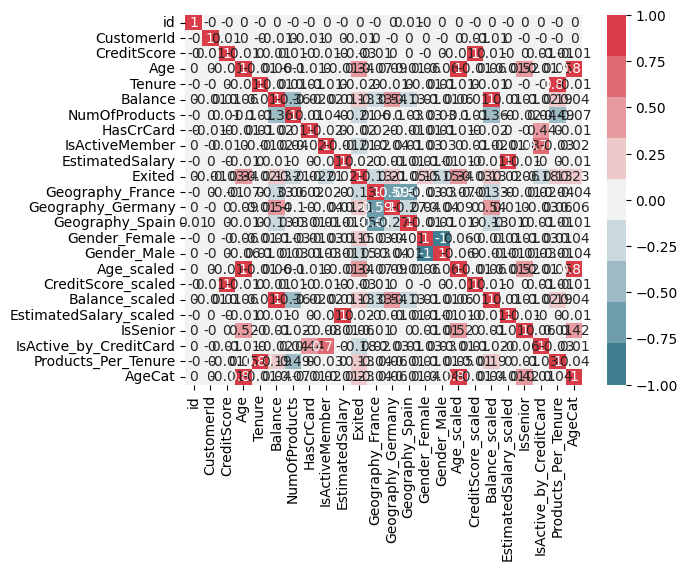

In [33]:
corr = df_train.corr().round(2)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True,
           cmap=sns.choose_diverging_palette())

In [39]:
X.dtypes 

CustomerId                   int64
Tenure                       int64
NumOfProducts                int64
HasCrCard                  float64
IsActiveMember             float64
Geography_France              bool
Geography_Germany             bool
Geography_Spain               bool
Gender_Female                 bool
Gender_Male                   bool
Age_scaled                 float64
CreditScore_scaled         float64
Balance_scaled             float64
EstimatedSalary_scaled     float64
IsSenior                     int64
IsActive_by_CreditCard     float64
Products_Per_Tenure        float64
AgeCat                    category
dtype: object

In [58]:
# never worked with CatBoost so this was based off someone elses work.
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)
    
    clf = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.03,
    iterations=n_est)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    
    y_pred_val = clf.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

0:	test: 0.8599588	best: 0.8599588 (0)	total: 130ms	remaining: 10m 51s
300:	test: 0.8904960	best: 0.8904960 (300)	total: 37.1s	remaining: 9m 38s
600:	test: 0.8914483	best: 0.8914483 (600)	total: 1m 13s	remaining: 8m 58s
900:	test: 0.8917433	best: 0.8917457 (896)	total: 1m 51s	remaining: 8m 26s
1200:	test: 0.8918662	best: 0.8918698 (1195)	total: 2m 28s	remaining: 7m 50s
1500:	test: 0.8919341	best: 0.8919346 (1499)	total: 3m 5s	remaining: 7m 13s
1800:	test: 0.8919156	best: 0.8919541 (1547)	total: 3m 43s	remaining: 6m 36s
2100:	test: 0.8918479	best: 0.8919541 (1547)	total: 4m 20s	remaining: 5m 58s
2400:	test: 0.8918120	best: 0.8919541 (1547)	total: 4m 57s	remaining: 5m 21s
2700:	test: 0.8917904	best: 0.8919541 (1547)	total: 5m 34s	remaining: 4m 45s
3000:	test: 0.8917558	best: 0.8919541 (1547)	total: 6m 13s	remaining: 4m 8s
3300:	test: 0.8917254	best: 0.8919541 (1547)	total: 6m 51s	remaining: 3m 31s
3600:	test: 0.8916523	best: 0.8919541 (1547)	total: 7m 29s	remaining: 2m 54s
3900:	test: 0.

In [59]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.8907598983116591)

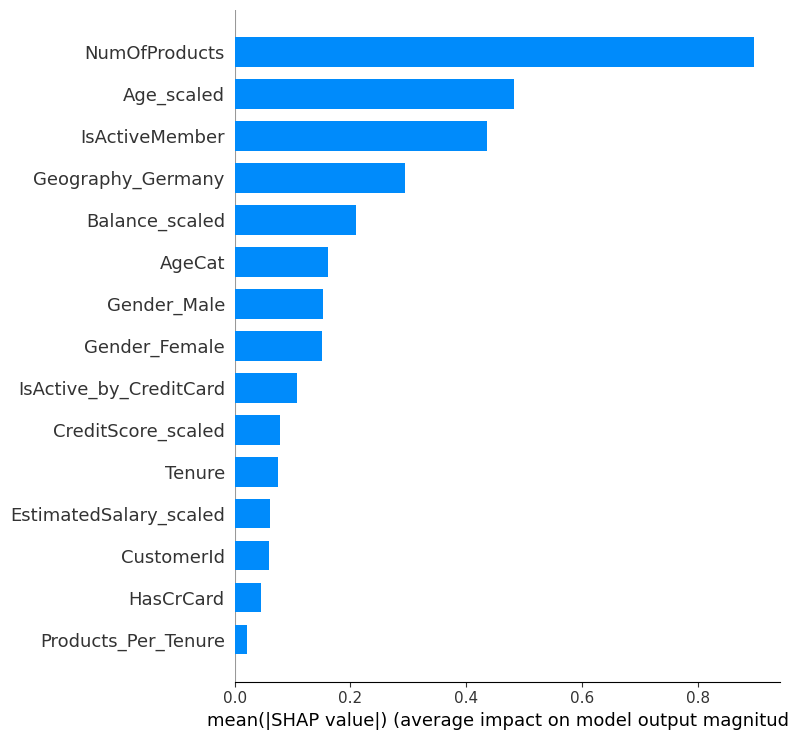

In [60]:
# Useful, should learn how it works
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [61]:
# it dended up worse with rounding to either 0 or 1
y_pred = test_preds.mean(axis=0)
####
d = {"id":test_encoded.id, "Exited":y_pred}
df_sub = pd.DataFrame(data=d)

In [62]:
df_sub.head()

,id,Exited
0,165034,0.022863
1,165035,0.845676
2,165036,0.023103
3,165037,0.209369
4,165038,0.354931


In [63]:
df_sub.to_csv(working_dir + "submission_v9_RemovedUselessCols.csv",index=False)